# 函数装饰器和闭包

## 装饰器基础知识

装饰器是可调用的对象，其参数是另一个函数（被装饰的函数，也支持类装饰器）。

装饰器可能会处理被装饰的函数，然后把它返回，或者将其替换成另一个函数或可调用对象。

装饰器只是语法糖，实际上是个可调用对象，其参数是另一个函数。

装饰器两大特性：
1. 能把被装饰函数替换成其他函数
2. 装饰器在加载模块时立即执行

## Python何时执行装饰器

装饰器一个关键特性：它们在被装饰的函数定义之后立即运行，通常是在导入时（即Python加载模块时）

装饰器在实际应用中的特点：
1. 装饰器通常在一个模块中定义，然后应用到其他模块中的函数上
2. 大多数装饰器会在内部定义一个函数，然后将其返回

## 装饰器改进的策略模式

利用装饰器注册策略函数

In [ ]:
promos = []

def promotion(promo_func):
    promos.append(promo_func)
    return promo_func

@promotion
def fidelity(order):
    return order.total() * .05 if order.customer.fidelity >= 1000 else 0

@promotion
def bulk_item(order):
    discount = 0
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * .1
    return discount

@promotion
def large_order(order):
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * .07
    return 0

def best_promo(order):
    return max(promo(order) for promo in promos)


## 变量作用域

Python不要求声明变量，但是假定在函数定义体中赋值的变量是局部变量

In [ ]:
b = 6
def f(a):
    print(a)
    print(b)
    b = 9
    
from dis import dis
dis(f)

f(3)

## 闭包

闭包是指延伸了作用域的函数，包含了函数定义体中引用，但不在定义体中定义的**非全局变量**

In [ ]:
def make_averager():
    series = []
    def averager(value):
        series.append(value)
        total = sum(series)
        return total / len(series)
    return averager

avg = make_averager()
print(avg(10))
print(avg(11))
print(avg(12))

print(avg.__code__.co_varnames)
print(avg.__code__.co_freevars)
avg.__closure__[0].cell_contents

**自由变量：**未在本地作用域中绑定的变量（averager函数中的series即自由变量）

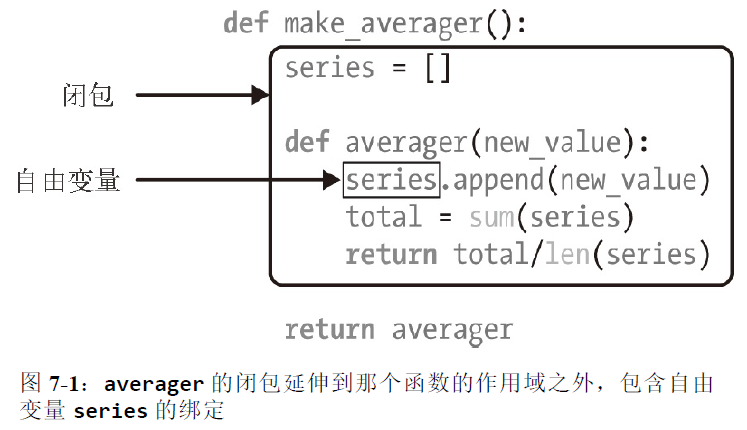

闭包是一种函数，它会保留定义函数时存在的自由变量的绑定。因此在调用函数时仍可使用自由变量，即使定义自由变量的作用域已经不可用了。

只有嵌套在其他函数中的函数才可能需要处理**不在全局作用域中的外部变量**。

## nonlocal声明

对于数字、字符串、元祖等不可变类型，只能读取而不能更新。如果尝试重新绑定，就会隐式创建局部变量，不再是自由变量了，因此也就不会保存在闭包中。

为了解决这个问题，Python3引入了nonlocal声明，作用是把变量标记为自由变量。即使函数中为变量赋了新值，也会当作自由变量

Python2中没有nonlocal，解决办法是，内部函数需要修改的不可变对象存储在可变的自由变量中

In [ ]:
def make_averager():
    count = 0
    total = 0
    
    def averager(new_value):
        nonlocal count, total
        count += 1
        total += new_value
        return total / count
    
    return averager

avg = make_averager()
print(avg(10))
print(avg(12))
print(avg.__code__.co_freevars)
print(avg.__code__.co_varnames)
print([cell.cell_contents for cell in avg.__closure__])

## 实现一个简单的装饰器


In [ ]:
import time

def clock(func):
    def clocked(*args):
        t0 = time.perf_counter()
        result = func(*args)
        elapsed = time.perf_counter() - t0
        
        name = func.__name__
        arg_str = ', '.join(repr(arg) for arg in args)
        print('[%0.8fs] %s(%s) -> %r' % (elapsed, name, arg_str, result))
        return result
    return clocked
@clock
def snooze(seconds):
    time.sleep(seconds)

snooze(.125)
print(snooze)

In [ ]:
import time
import functools

def clock(func):
    @functools.wraps(func)
    def clocked(*args, **kwargs):
        t0 = time.perf_counter()
        result = func(*args, **kwargs)
        elapsed = time.perf_counter() - t0
        
        name = func.__name__
        arg_list = []
        if args:
            arg_list.append(', '.join(repr(arg) for arg in args))
        if kwargs:
            pairs = ['%s=%r' % (k, w) for k, w in sorted(kwargs.items())]
            arg_list.append(', '.join(pairs))
        arg_str = ', '.join(arg_list)
        print('[%0.8fs] %s(%s) -> %r' % (elapsed, name, arg_str, result))
        return result
    return clocked

@clock
def snooze(seconds = .125):
    time.sleep(seconds)

snooze(seconds = .25)
print(snooze)

## 标准库中的装饰器

Python内置三个用于装饰方法的函数：property,classmethod和staticmethod

functools.wraps是用来协助构建行为良好的装饰器的函数

functools.lru_cache用来做备忘(memoization) 签名：functools.lru_cache(maxsize=128, type=False)

maxsize指定存储多少个调用结果，缓存满后，就的结果被丢弃。为了最佳性能，maxsize应该设置为2的幂。

typed参数如果设为True,不同参数类型的结果会分开保存，即把通常认为相等的浮点数和整数参数（1和1.0）区分开。

lru_cache使用字典存储结果，且键根据调用时传入的定位参数和关键字参数创建，所以lru_cache装饰的函数，所有参数必须可散列。

In [ ]:
@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n - 2) + fibonacci(n - 1)

fibonacci(6)

In [ ]:
@functools.lru_cache()
@clock
def fibonacci(n):
    if n < 2:
        return n
    return fibonacci(n - 2) + fibonacci(n - 1)

fibonacci(6)
print(fibonacci)

### 单分派泛函数

Python不支持重载方法或函数，故不能使用不同的签名定义方法的变体，因此不能用不同的方法处理不同类型的数据。

一种解决办法是改为分派函数，根据条件分派逻辑到不同函数。但这么做很不利于扩展，而且分派函数与各专门函数耦合度高。

Python3.4新增的functools.singledispatch装饰器可以把整体方案拆分成多个模块。

将普通函数装饰成一组泛函数：根据**第一个参数**（单分派）的类型，以不同方式执行相同操作的一组函数。

In [ ]:
from functools import singledispatch
from collections import abc
import numbers
import html

@singledispatch
def htmlize(obj): #singledispatch标记基函数
    content = html.escape(repr(obj))
    return '<pre>{}</pre>'.format(content)

@htmlize.register(str)  #专门函数用 @<<base_function>>.register(<<type>>)来装饰
def _(text):  #专门函数的民称无关紧要
    content = html.escape(text).replace('\n', '<br>\n')
    return '<p>{0}</p>'.format(content)

@htmlize.register(numbers.Integral)
def _(n):
    return '<pre>{0} 0x{0:x}</pre>'.format(n)

@htmlize.register(tuple)
@htmlize.register(abc.MutableSequence)
def _(seq):
    inner = '</li>\n<li>'.join(htmlize(item) for item in seq)
    return '<ul>\n<li>{0}</li>\n</ul>'.format(inner)

print(htmlize({1, 2, 3}))
print(htmlize('Hi & Py\nthon!'))
print(htmlize(10))
print(htmlize(['apple', 'banana', 'orange']))
print(htmlize((1, 2)))

singledispatch机制一个特征：可以在系统的任何地方任何模块中注册专门函数

支持模块化扩展：各个模块可以为它支持的各个类型注册一个专门函数

## 参数化装饰器

要为装饰器提供参数，需把装饰器包装在工厂函数中返回，工厂函数可以接受参数，并让内部的装饰函数从闭包获取参数使用